In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from math import floor
import cv2

In [17]:
def imhist(input_array):
    m, n = input_array.shape
    h = [0.0] * 256
    for i in range(m):
        for j in range(n):
            h[int(input_array[i, j])]+=1
    return np.array(h)/(m*n)

def calcCLAHEVal(input_array,th):
    r,c = input_array.shape
    H = imhist(input_array)
    C = zeros_like(H)
    for i in range(256):
        if H[i] > th:
            H[i] = th
    contrastArea = 1 - sum(H)
    height = contrastArea/256
    H = H + height
    C[0] = H[0]
    
    for i in range(1,256):
        C[i] = C[i-1] + (H[i])

    return C

def myCLAHE(input_file,window_x,window_y,threshold,cmap):
    name = input_file.split(".")[2]
    input_image = cv2.imread(input_file,)
    output_image = zeros_like(input_image)
    d=1
    if len(input_image.shape)<3:
        r,c = input_image.shape
    else:
        r,c,d = input_image.shape

    
    if d==1:
        new_image = input_image
        
        for i in tqdm(range(r)):
            for j in range(c):
                min_x = max(0,i-window_x)
                min_y = max(0,j-window_y)
                max_x = min(r,i+window_x)
                max_y = min(c,j+window_y)
                
                window_image = input_image[min_x:max_x,min_y:max_y]
                if new_image[i,j]!=0:
                    x = calcCLAHEVal(window_image,threshold)
                    output_image[i,j] = x[int(new_image[i,j])]*255
                
    else:
        output_lab = np.zeros_like(input_image)
        lab_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2LAB)
        l_channel,a_channel,b_channel = cv2.split(lab_image)

        out_l_channel = l_channel.copy()
        
        for i in tqdm(range(r)):
            for j in range(c):
                min_x = max(0,i-window_x)
                min_y = max(0,j-window_y)
                max_x = min(r,i+window_x)
                max_y = min(c,j+window_y)
                
                window_image = l_channel[min_x:max_x,min_y:max_y]
                if out_l_channel[i,j]!=0:
                    x = calcCLAHEVal(window_image,threshold)
                    out_l_channel[i,j] = x[int(l_channel[i,j])]*255

            output_lab[:,:,0] = out_l_channel
            output_lab[:,:,1] = a_channel
            output_lab[:,:,2] = b_channel
            
            output_image = cv2.cvtColor(output_lab,cv2.COLOR_LAB2RGB)
                    
    fig,axes = plt.subplots(1,2, constrained_layout=True)
    axes[0].imshow(input_image,cmap=cmap)
    axes[0].axis("on")
    axes[0].set_title("Original Image")
    im = axes[1].imshow(output_image,cmap=cmap)
    axes[1].axis("on")
    axes[1].set_title("CLAHE Image")
    cbar = fig.colorbar(im,ax=axes.ravel().tolist(),shrink=0.45)
    
    plt.savefig(".."+name+"HistEq.png",bbox_inches="tight",pad=-1)
#     plt.imshow(output_image,cmap=cmap)
#     plt.axis("off")
    #output_image = cv2.cvtColor(output_image,cv2.COLOR_BGR2RGB)
    #plt.imshow(output_image,cmap=cmap)

#    plt.imsave(".." + name+"CLAHE.png",output_image,cmap=cmap)

100%|██████████| 512/512 [01:30<00:00,  5.64it/s]


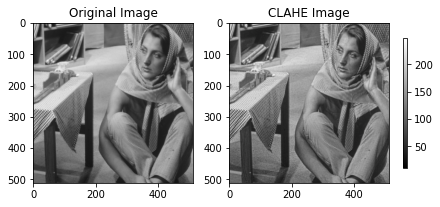

In [18]:
input_file = "../data/barbara.png"
myCLAHE(input_file,4,4,0.005,"gray")

In [ ]:
input_file = "../data/TEM.png"
myCLAHE(input_file,32,32,0.03,"gray")

In [16]:
input_file = "../data/church.png"
myCLAHE(input_file,64,64,0.015,"gray")

  4%|▎         | 44/1200 [05:13<2:17:11,  7.12s/it]


KeyboardInterrupt: 

In [ ]:
input_file = "../data/canyon.png"
myCLAHE(input_file,16,16,0.005,"gray")

In [ ]:
input_file = "../data/chestXray.png"
myCLAHE(input_file,8,8,0.015,"gray")